Let's see if we can find some better thresholds and get even better classification with higher precision and recall.
Also, let's check how much cost we can save based on the number of frauds identified.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv(r"C:\Users\dhanu\OneDrive\Documents\books academic\p-1\datasets\creditcard1.csv~\creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
# separate features and target variables

X = df.drop(columns = ["Class"])
Y = df["Class"]

# split the data into training and testing sets, including stratification to maintain class distribution
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

fraud_train = y_train[y_train == 1].shape[0]
normal_train = y_train[y_train == 0].shape[0]

fraud_test = y_test[y_test == 1].shape[0]
normal_test = y_test[y_test == 0].shape[0]

print("Fraud samples in Training data : ", fraud_train)
print("Normal samples in Training data : ", normal_train, "\n")

print("Fraud samples in Testing data : ", fraud_test)
print("Normal samples in Testing data : ", normal_test)

Fraud samples in Training data :  394
Normal samples in Training data :  227451 

Fraud samples in Testing data :  98
Normal samples in Testing data :  56864


### 1. Feature Importance and Best Threshold for XGBoosting model

In [20]:
xgb_model = XGBClassifier(
    n_estimators=200, max_depth=4, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="logloss", use_label_encoder=False,
    random_state=42, n_jobs=-1
)

xgb_model.fit(X_resampled, y_resampled)

c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:30:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


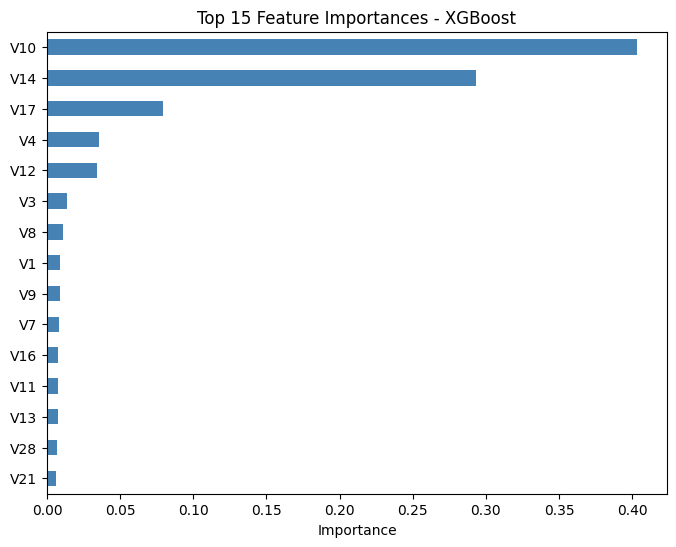

In [22]:
def plot_feature_importance(model, feature_names, top_n=15, model_name="XGBoost"):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    else:
        raise AttributeError(f"{model_name} does not support feature importance.")
    
    feat_imp = pd.Series(importance, index=feature_names).sort_values(ascending=False).head(top_n)
    
    plt.figure(figsize=(8, 6))
    feat_imp.plot(kind='barh', color='steelblue')
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.show()


plot_feature_importance(xgb_model, x_train.columns, model_name="XGBoost")

Based on feature_importances_, we can observe in the graph that V10, V14, V17 are most important features during training.

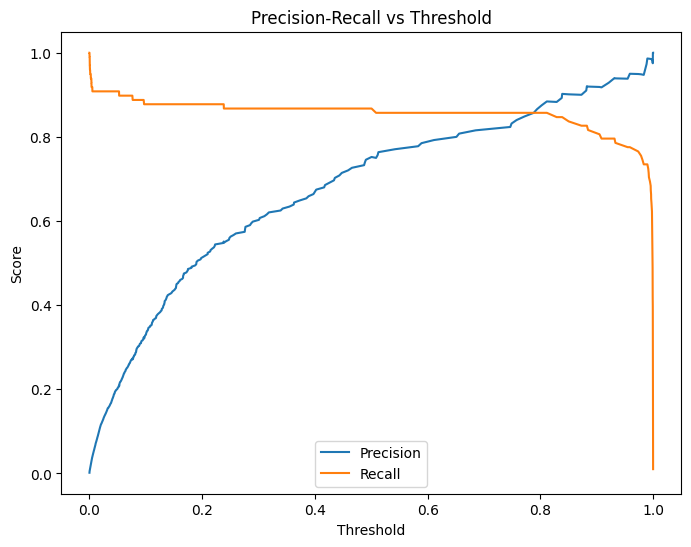

In [ ]:
# finding best threshold based on precision vs recall plot

def plot_threshold_curve(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision-Recall vs Threshold")
    plt.legend()
    plt.show()

# After predicting probabilities:
y_proba = xgb_model.predict_proba(x_test)[:, 1]
plot_threshold_curve(y_test, y_proba)

From the precision recall curve, we can identify that the balance between precision and recall can be obtained at the threshold of ~0.8. At this threshold, we can identify maximum number of frauds (high precision) with less number of false positives (high recall).

c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


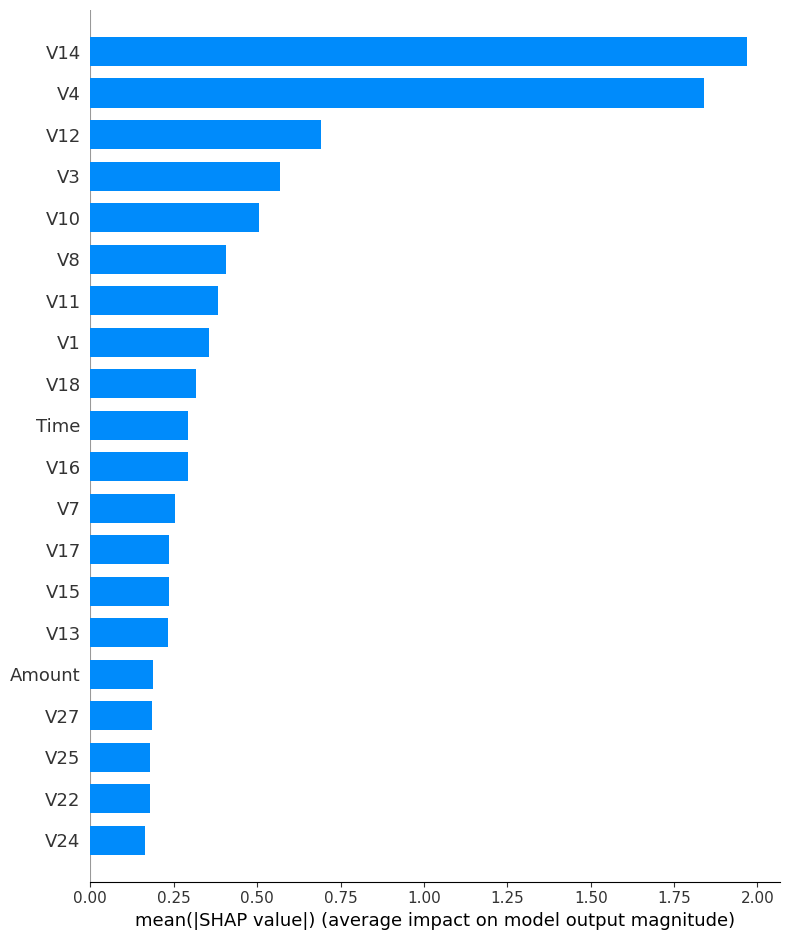

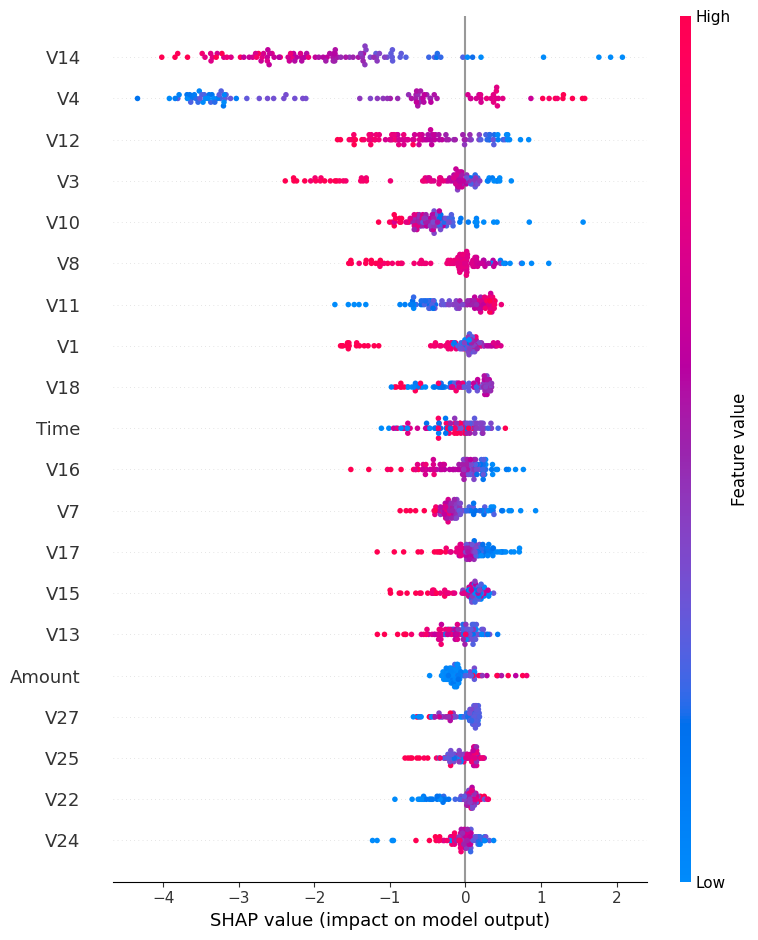

In [29]:
import shap

def explain_with_shap(model, X_sample):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    shap.summary_plot(shap_values, X_sample, plot_type="bar")
    shap.summary_plot(shap_values, X_sample)

# Use a small sample for speed:
explain_with_shap(xgb_model, x_test.sample(100, random_state=42))

#### Model Interpretability using SHAP
- The SHAP (SHapley Additive exPlanations) summary plot shows the impact of each feature on the model’s predictions for fraud detection.
- Each row represents a feature, sorted by its importance.
- The X-axis (SHAP value) indicates how much a feature pushes a prediction toward fraud (positive) or non-fraud (negative).
- Each dot represents a transaction, with color showing feature value (blue = low, red = high).

From the plot:
V14, V4, and V12 are the most influential features for detecting fraud. Low V14 values strongly indicate non-fraud, while high V14 values push predictions toward fraud. Amount and Time have relatively low impact compared to the top PCA-based features.

### 2. Business Modelling

Let's give us some amount that we can save based on number of fraud that we are able to identify using the best model.
And also let's assume we only investigate some normal transactions (since it is not possible to check each and every normal transaction),
and investigating each normal transaction also has some price to it.

By this way, we will see how much we need to invest to detect a fraud and to investigate a normal transaction, based on which we can see total fraud preventions.

In [ ]:
def business_cost_analysis( y_true, y_pred, y_proba,amounts, fp_cost = 10, fn_cost = 500):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Amounts for fraud transactions (y_true = 1)
    fraud_amounts = amounts[y_true == 1]
    
    # Amounts for correctly detected frauds (True Positives)
    saved_amount = amounts[(y_true == 1) & (y_pred == 1)].sum()
    
    # Amounts for missed frauds (False Negatives)
    lost_amount = amounts[(y_true == 1) & (y_pred == 0)].sum()
    
    # Cost for investigating false positives
    investigation_cost = fp * fp_cost
    
    # Net savings = money saved - money lost - investigation cost
    net_savings = saved_amount - (lost_amount + investigation_cost)

    print(f"True Positives (Fraud Detected): {tp} transactions | Saved €{saved_amount:,.2f}")
    print(f"False Negatives (Fraud Missed): {fn} transactions | Lost €{lost_amount:,.2f}")
    print(f"False Positives (Normal flagged): {fp} transactions | Investigation Cost €{investigation_cost:,.2f}")
    print(f"Net Savings: €{net_savings:,.2f}") 

    return {
        "TP": tp, "FP": fp, "FN": fn,
        "Saved_Amount": saved_amount,
        "Lost_Amount": lost_amount,
        "Investigation_Cost": investigation_cost,
        "Net_Savings": net_savings
    }

# let's keep the default threshold to be around 0.3
results = business_cost_analysis(
    y_true = y_test.values,
    y_pred = (y_proba >= 0.3).astype(int),
    y_proba = y_proba, 
    amounts = x_test["Amount"].values
)


True Positives (Fraud Detected): 85 transactions | Saved €8,814.21
False Negatives (Fraud Missed): 13 transactions | Lost €1,830.72
False Positives (Normal flagged): 56 transactions | Investigation Cost €560.00
Net Savings: €6,423.49


In [ ]:
# from the precision recall curve, optimal threshold was identified to be 0.8
# so let's see how much we can save if we set this new threshold for our problem

results = business_cost_analysis(
    y_true = y_test.values,
    y_pred = (y_proba >= 0.8).astype(int),
    y_proba = y_proba, 
    amounts = x_test["Amount"].values
)

True Positives (Fraud Detected): 84 transactions | Saved €8,813.21
False Negatives (Fraud Missed): 14 transactions | Lost €1,831.72
False Positives (Normal flagged): 12 transactions | Investigation Cost €120.00
Net Savings: €6,861.49
